# Objective 1: Implementation Validation

This notebook validates our fluid simulation implementation through:
1. Visual inspection of fluid flow containment
2. Verification of mass conservation (divergence ≈ 0)
3. Checking for boundary leakage/artifacts
4. Monitoring density field constancy
5. Assessing numerical stability

In [28]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import glob
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

## Load Simulation Parameters

In [29]:
# Define the base directory where the simulation results are located
base_dir = Path.cwd()

# Define the simulation folder path for the time-dependent Zouhe standard BGK simulation
simulation_folder = base_dir / '../results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh'

# Path to the parameter JSON file
param_file = simulation_folder / 'parameters' / 'aneurysm_params.json'

# Load and parse the parameters
with open(param_file, 'r') as f:
    params = json.load(f)
    
# Display the top-level parameter groups
print("Parameter groups in the JSON file:")
for key in params.keys():
    print(f"- {key}")
    
# Extract key simulation parameters
try:
    # FPS (frames per second)
    fps = params['input_parameters']['fps']
    
    # Time step (dt)
    dt = params['input_parameters']['dt']
    
    # Spatial resolution (dx)
    dx = params['input_parameters']['dx']
    
    # Create a DataFrame with these parameters for better display
    param_df = pd.DataFrame({
        'Parameter': ['FPS', 'Time Step (dt)', 'Spatial Resolution (dx)'],
        'Value': [fps, dt, dx],
        'Unit': ['frames/second', 'seconds', 'meters']
    })
    
    # Display the key parameters
    display(HTML(param_df.to_html(index=False)))
    
    # Store additional useful parameters
    vessel_length_mm = params['input_parameters']['vessel_length_mm']
    vessel_diameter_mm = params['input_parameters']['vessel_diameter_mm']
    
    # Print physical dimensions
    print("\nPhysical dimensions:")
    print(f"Vessel length: {vessel_length_mm} mm")
    print(f"Vessel diameter: {vessel_diameter_mm} mm")
    
except KeyError as e:
    print(f"Error: Could not find parameter {e} in the JSON file.")
    print("Check the structure of the parameter file.")

Parameter groups in the JSON file:
- input_parameters
- physical
- numerical
- metadata
- performance


Parameter,Value,Unit
FPS,100.00000,frames/second
Time Step (dt),0.00001,seconds
Spatial Resolution (dx),0.00002,meters



Physical dimensions:
Vessel length: 15 mm
Vessel diameter: 6.5 mm


## Data Loading

Load simulation data from files.

In [30]:
# Define default simulation directory as fallback
simulation_dir = '../simulation_output/'

# Function to load simulation data
def load_simulation_data(directory):
    """
    Load simulation data files from the specified directory.
    Returns a dictionary of loaded data arrays.
    """
    data = {}
    try:
        # First try to load from processed data directory if using the new structure
        if isinstance(directory, Path) and (directory / 'processed_data' / 'raw_fields').exists():
            processed_dir = directory / 'processed_data' / 'raw_fields'
            print(f"Looking for data in: {processed_dir}")
            
            try:
                # Load velocity fields if available
                if (processed_dir / 'u_x.npz').exists() and (processed_dir / 'u_y.npz').exists():
                    data['u'] = np.load(processed_dir / 'u_x.npz')['data'][0]  # First frame
                    data['v'] = np.load(processed_dir / 'u_y.npz')['data'][0]  # First frame
                    print(f"Loaded velocity data with shape: {data['u'].shape}")
            except Exception as e:
                print(f"Error loading from processed directory: {e}")
        
        # If no data loaded yet, try the standard directory structure
        if not data:
            if isinstance(directory, str):
                dir_path = directory
            else:
                dir_path = str(directory)
                
            print(f"Looking for data in: {dir_path}")
            # Try to load velocity fields
            velocity_x_path = os.path.join(dir_path, 'velocity_x.npy')
            velocity_y_path = os.path.join(dir_path, 'velocity_y.npy')
            
            if os.path.exists(velocity_x_path) and os.path.exists(velocity_y_path):
                data['u'] = np.load(velocity_x_path)
                data['v'] = np.load(velocity_y_path)
                print(f"Loaded velocity data with shape: {data['u'].shape}")
            else:
                print("Velocity data files not found.")
                
    except Exception as e:
        print(f"Error loading data: {e}")
    
    return data

# Load the data
sim_data = load_simulation_data(simulation_folder)

# If no data was found in the simulation folder, try the default directory
if not sim_data:
    print("Falling back to default simulation directory")
    sim_data = load_simulation_data(simulation_dir)

Looking for data in: /home/abdua786/code/uni/3/dissertation/dissertation/visualisation_src/../results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh/processed_data/raw_fields
Loaded velocity data with shape: (528, 749)
Loaded velocity data with shape: (528, 749)


## 1. Fluid Flow Containment Visualization

Visualize the velocity field to verify fluid is contained within the domain.

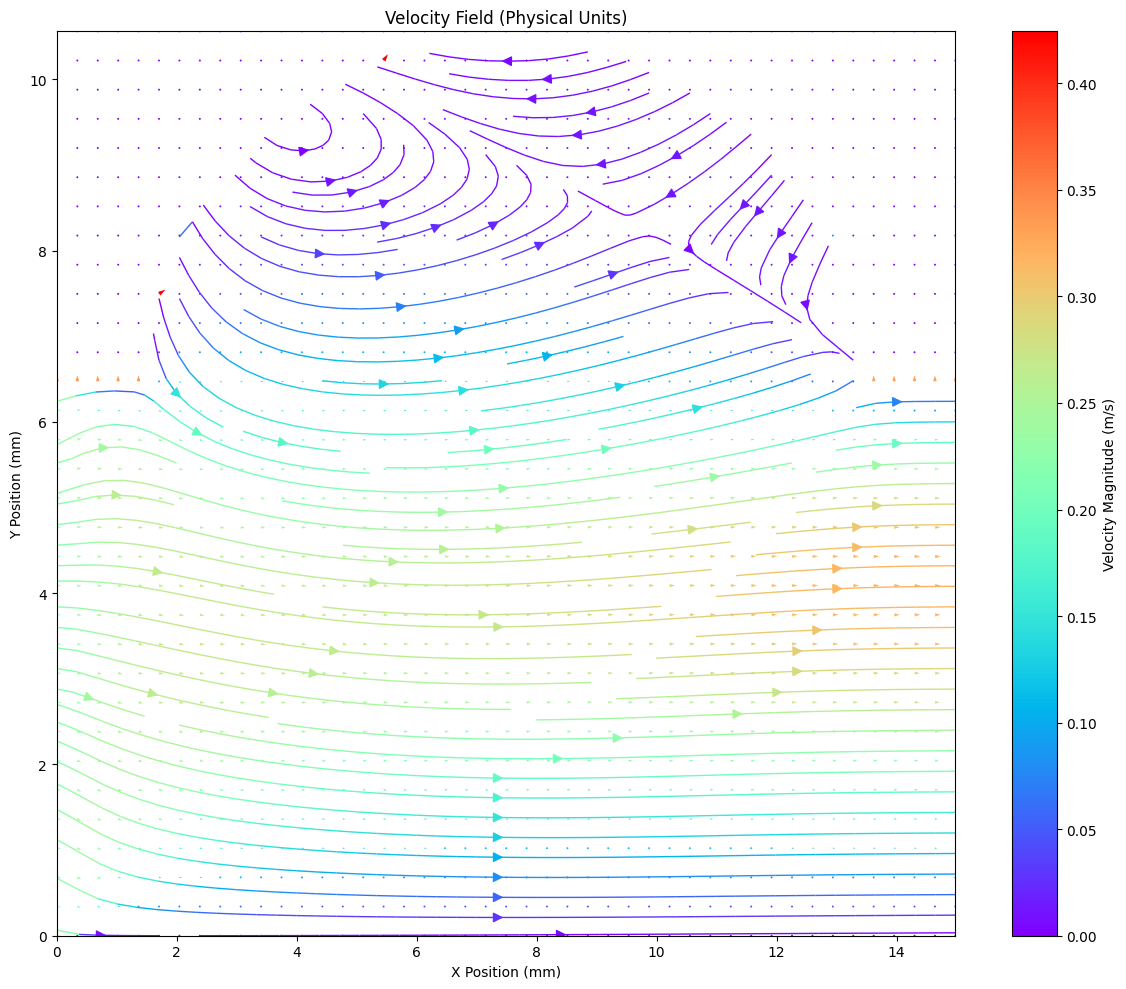

In [31]:
def plot_velocity_field(u, v, title="Velocity Field"):
    """
    Plot the velocity field as a quiver plot to visualize flow direction and magnitude.
    """
    if u is None or v is None or len(u) == 0 or len(v) == 0:
        print("Velocity data not available or empty")
        return
    
    # Determine if reshaping is needed
    if u.ndim == 1:
        # Assuming data is from a 2D simulation with dimensions available in params
        try:
            grid_shape = params['numerical']['grid_shape']
            # Extract the 2D dimensions (removing any dimensions of size 1)
            dims = [dim for dim in grid_shape if dim > 1]
            if len(dims) == 2:
                ny, nx = dims[0], dims[1]
                u = u.reshape(ny, nx)
                v = v.reshape(ny, nx)
                print(f"Reshaped velocity data to {u.shape}")
            else:
                print("Could not determine 2D shape from parameters")
                return
        except (KeyError, IndexError) as e:
            print(f"Error reshaping data: {e}")
            return
    
    # Create a figure
    plt.figure(figsize=(12, 10))
    
    # Calculate velocity magnitude for coloring
    vel_mag = np.sqrt(u**2 + v**2)
    
    # Convert to physical units (m/s)
    vel_mag_phys = vel_mag * (dx / dt)
    u_phys = u * (dx / dt)
    v_phys = v * (dx / dt)
    
    # Create a grid for quiver plot with physical units (mm)
    ny, nx = u.shape
    x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
    y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
    X_mm, Y_mm = np.meshgrid(x_mm, y_mm)
    
    # Downsample for clearer visualization if needed
    skip = max(1, min(nx, ny) // 30)  # Adjust based on grid density
    
    # Plot streamlines with physical units
    plt.streamplot(X_mm, Y_mm, u_phys, v_phys, density=1.5, color=vel_mag_phys, 
                    linewidth=1, cmap='rainbow', arrowsize=1.5)
    
    # Plot velocity vectors with physical units
    plt.quiver(X_mm[::skip, ::skip], Y_mm[::skip, ::skip], 
              u_phys[::skip, ::skip], v_phys[::skip, ::skip], 
              vel_mag_phys[::skip, ::skip], cmap='rainbow', scale=50)
    
    plt.colorbar(label='Velocity Magnitude (m/s)')
    plt.title(title)
    plt.xlabel('X Position (mm)')
    plt.ylabel('Y Position (mm)')
    plt.tight_layout()
    plt.show()

# Plot the velocity field if data is available
if 'u' in sim_data and 'v' in sim_data:
    plot_velocity_field(sim_data['u'], sim_data['v'], title="Velocity Field (Physical Units)")
else:
    print("Velocity data not available for visualization.")

## Density Field Visualization After 1 Second

Visualize the density (rho) field of the aneurysm simulation after 1 second of simulation time to verify density distribution.

Found frame 100000 at time 1.000s (closest to 1.0s)


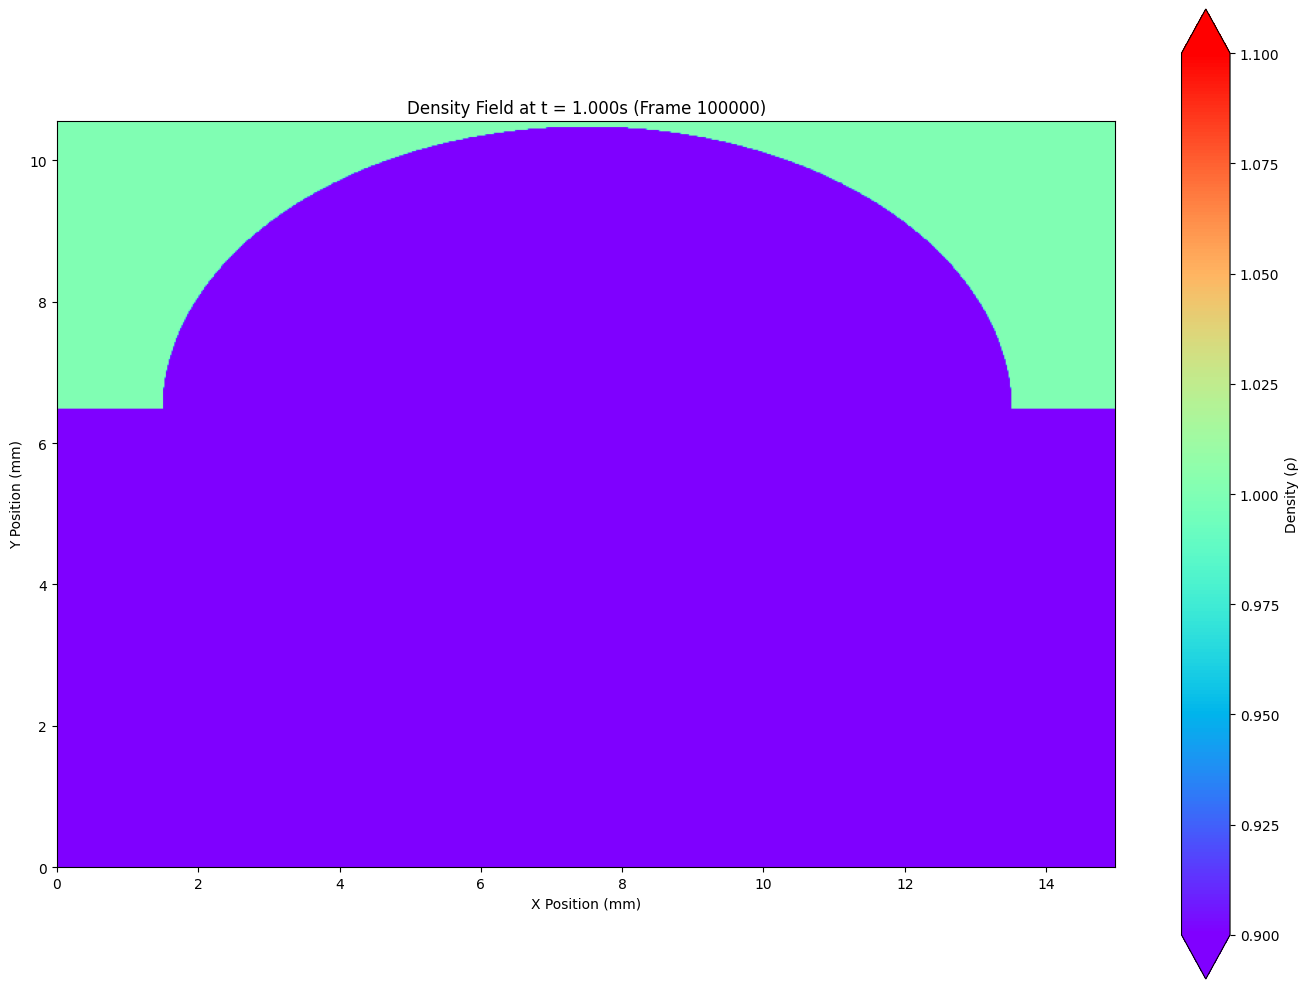

Density Field Assessment:
  Mean density: 0.501328
  Density variation (std): 0.209862
  Min density: 0.380371
  Max density: 1.000000
  Range: 0.619629
❌ Density field shows significant variations - potential numerical instability


In [32]:
# Define the processed data directory
processed_dir = simulation_folder / 'processed_data' / 'raw_fields'

def load_density_field(directory, time_sec=1.0):
    """Load density field at approximately 1 second of simulation time"""
    try:
        # First, check if we have the frame mapping to find the correct frame number
        if (directory / 'frame_mapping.npz').exists():
            frame_mapping = np.load(directory / 'frame_mapping.npz')
            frame_numbers = frame_mapping['frame_numbers']
            
            # Convert frame numbers to physical time
            physical_times = frame_numbers * dt
            
            # Find frame closest to 1 second
            target_frame_idx = np.argmin(np.abs(physical_times - time_sec))
            target_frame_num = frame_numbers[target_frame_idx]
            actual_time = physical_times[target_frame_idx]
            
            print(f"Found frame {target_frame_num} at time {actual_time:.3f}s (closest to {time_sec:.1f}s)")
            
            # Check if density field exists
            if (directory / 'rho.npz').exists():
                rho_data = np.load(directory / 'rho.npz')['data']
                if rho_data.ndim == 3:  # Multi-frame data
                    return {
                        'rho': rho_data[target_frame_idx],
                        'frame': target_frame_num,
                        'time': actual_time
                    }
                else:
                    print("Density data format is not as expected (not multi-frame)")
            else:
                print(f"Density field data not found at {directory / 'rho.npz'}")
                
                # Check if we can load wall mask for domain visualization
                if (directory / 'wall_mask.npz').exists():
                    wall_mask = np.load(directory / 'wall_mask.npz')['data']
                    if wall_mask.ndim == 3:  # Multi-frame data
                        print("Wall mask found - will use for visualization")
                        return {
                            'wall_mask': wall_mask[target_frame_idx],
                            'frame': target_frame_num,
                            'time': actual_time
                        }
        else:
            print(f"Frame mapping not found at {directory / 'frame_mapping.npz'}")
            
    except Exception as e:
        print(f"Error loading density data: {e}")
    
    return None

def plot_density_field(data, wall_mask=None):
    """Visualize the density field with domain boundaries"""
    if data is None or 'rho' not in data and 'wall_mask' not in data:
        print("No density or domain data available to visualize")
        return
    
    # Create a figure
    plt.figure(figsize=(14, 10))
    
    # Get time information for the title
    frame_num = data.get('frame', 'unknown')
    time_sec = data.get('time', 'unknown')
    
    # Get grid dimensions in physical units (mm)
    if 'rho' in data:
        ny, nx = data['rho'].shape
    elif 'wall_mask' in data:
        ny, nx = data['wall_mask'].shape
    else:
        return  # No data to visualize
        
    # Physical dimensions
    x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
    y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
    extent_mm = [0, max(x_mm), 0, max(y_mm)]  # [left, right, bottom, top] in mm
    
    # Plot density if available
    if 'rho' in data:
        rho = data['rho']
        
        # Calculate statistics
        rho_min = np.min(rho)
        rho_max = np.max(rho)
        rho_mean = np.mean(rho)
        rho_std = np.std(rho)
        
        # Create custom color range centered around 1.0 (expected equilibrium density)
        vmin = max(0.9, rho_min - 0.1)  # don't go below 0.9 typically
        vmax = min(1.1, rho_max + 0.1)  # don't go above 1.1 typically
        
        # Plot the density field with rainbow colormap
        im = plt.imshow(rho, cmap='rainbow', origin='lower', vmin=vmin, vmax=vmax, extent=extent_mm)
        plt.colorbar(im, label='Density (ρ)', extend='both')
        
        # Add domain boundary as contour if wall mask is available
        if 'wall_mask' in data:
            wall_mask = data['wall_mask']
            plt.contour(np.linspace(0, max(x_mm), nx), np.linspace(0, max(y_mm), ny), 
                        wall_mask, levels=[0.5], colors='black', linewidths=0.5)
                     
        plt.title(f"Density Field at t = {time_sec:.3f}s (Frame {frame_num})")
        
    # If only wall mask is available, plot it
    elif 'wall_mask' in data:
        wall_mask = data['wall_mask']
        plt.imshow(wall_mask, origin='lower', cmap='gray', extent=extent_mm)
        plt.colorbar(label='Domain Mask')
        plt.title(f"Domain Mask at t = {time_sec:.3f}s (Frame {frame_num})")
    
    plt.xlabel('X Position (mm)')
    plt.ylabel('Y Position (mm)')
    plt.tight_layout()
    plt.show()
    
    # Print assessment of density field constancy (if available)
    if 'rho' in data:
        print(f"Density Field Assessment:")
        print(f"  Mean density: {rho_mean:.6f}")
        print(f"  Density variation (std): {rho_std:.6f}")
        print(f"  Min density: {rho_min:.6f}")
        print(f"  Max density: {rho_max:.6f}")
        print(f"  Range: {rho_max - rho_min:.6f}")
        
        # Assessment criteria
        if rho_std < 0.001 and abs(rho_mean - 1.0) < 0.01:
            print("✅ Density field is very stable and close to expected equilibrium value of 1.0")
        elif rho_std < 0.01 and abs(rho_mean - 1.0) < 0.05:
            print("⚠️ Density field shows minor variations but is generally acceptable")
        else:
            print("❌ Density field shows significant variations - potential numerical instability")

# Load and plot the density field at ~1 second of simulation time
density_data = load_density_field(processed_dir, time_sec=1.0)

# If we couldn't load density but have wall mask, try loading that for comparison
if density_data is None or 'rho' not in density_data:
    print("\nAttempting to load other fields for visualization...")
    # Try to load velocity magnitude as a proxy for flow field visualization
    if (processed_dir / 'u_magnitude.npz').exists() and (processed_dir / 'frame_mapping.npz').exists():
        frame_mapping = np.load(processed_dir / 'frame_mapping.npz')
        frame_numbers = frame_mapping['frame_numbers']
        physical_times = frame_numbers * dt
        target_frame_idx = np.argmin(np.abs(physical_times - 1.0))
        
        u_mag_data = np.load(processed_dir / 'u_magnitude.npz')['data']
        if u_mag_data.ndim == 3:
            target_u_mag = u_mag_data[target_frame_idx]
            ny, nx = target_u_mag.shape
            
            # Convert to physical units (m/s) and create physical coordinate grid (mm)
            u_mag_phys = target_u_mag * (dx / dt)  # Convert to m/s
            x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
            y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
            extent_mm = [0, max(x_mm), 0, max(y_mm)]
            
            plt.figure(figsize=(14, 10))
            plt.imshow(u_mag_phys, origin='lower', cmap='rainbow', extent=extent_mm)
            plt.colorbar(label='Velocity Magnitude (m/s)')
            plt.title(f"Velocity Magnitude at t = {physical_times[target_frame_idx]:.3f}s (Frame {frame_numbers[target_frame_idx]})")
            plt.xlabel('X Position (mm)')
            plt.ylabel('Y Position (mm)')
            plt.tight_layout()
            plt.show()
            
            print("\nNote: Displayed velocity magnitude instead of density field")
            print("Density field data may not be available in this simulation output")

# Plot density data if available
if density_data:
    plot_density_field(density_data)

## 2. Conservation of Mass Verification

Calculate and visualize divergence to verify mass conservation (should be close to zero).

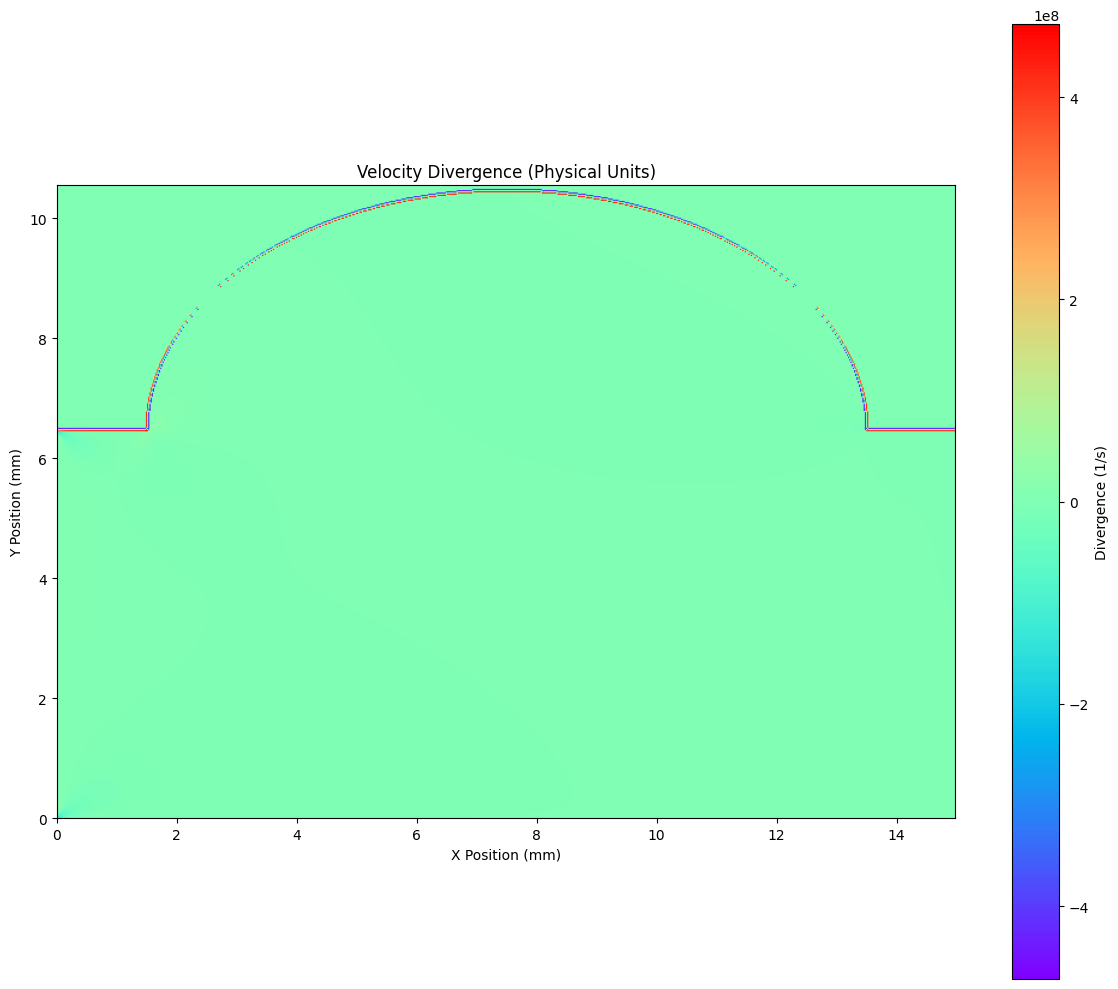

Divergence Statistics:
  Mean: -1.790592e+04 (1/s)
  Max: 4.652410e+08 (1/s)
  Min: -4.721577e+08 (1/s)
  RMS: 2.401222e+07 (1/s)
❌ Divergence is significant - Mass conservation violation detected


In [33]:
def calculate_divergence(u, v, dx=1.0, dy=1.0):
    """
    Calculate the divergence of the velocity field.
    For incompressible flow, this should be close to zero.
    """
    if u is None or v is None or u.ndim != 2 or v.ndim != 2:
        print("Velocity data not available in correct format")
        return None
    
    # Calculate partial derivatives using central differences
    du_dx = np.zeros_like(u)
    dv_dy = np.zeros_like(v)
    
    # Interior points
    du_dx[:, 1:-1] = (u[:, 2:] - u[:, :-2]) / (2 * dx)
    dv_dy[1:-1, :] = (v[2:, :] - v[:-2, :]) / (2 * dy)
    
    # Boundary points - use forward/backward differences
    du_dx[:, 0] = (u[:, 1] - u[:, 0]) / dx
    du_dx[:, -1] = (u[:, -1] - u[:, -2]) / dx
    dv_dy[0, :] = (v[1, :] - v[0, :]) / dy
    dv_dy[-1, :] = (v[-1, :] - v[-2, :]) / dy
    
    # Calculate divergence
    divergence = du_dx + dv_dy
    
    return divergence

def plot_divergence(divergence, title="Velocity Divergence"):
    """
    Plot the divergence field to visualize mass conservation violations.
    """
    if divergence is None:
        return
    
    # Get dimensions in physical units (mm)
    ny, nx = divergence.shape
    x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
    y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
    extent_mm = [0, max(x_mm), 0, max(y_mm)]
    
    plt.figure(figsize=(12, 10))
    
    # Create a custom colormap centered at zero
    max_abs_div = max(abs(np.max(divergence)), abs(np.min(divergence)))
    vmin, vmax = -max_abs_div, max_abs_div
    
    # Plot divergence as a heatmap with physical units (using rainbow colormap)
    im = plt.imshow(divergence, cmap='rainbow', vmin=vmin, vmax=vmax, origin='lower', extent=extent_mm)
    plt.colorbar(im, label='Divergence (1/s)')
    plt.title(title)
    plt.xlabel('X Position (mm)')
    plt.ylabel('Y Position (mm)')
    
    # Calculate statistics for reporting (but don't display on plot)
    avg_div = np.mean(divergence)
    max_div = np.max(divergence)
    min_div = np.min(divergence)
    rms_div = np.sqrt(np.mean(divergence**2))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Divergence Statistics:")
    print(f"  Mean: {avg_div:.6e} (1/s)")
    print(f"  Max: {max_div:.6e} (1/s)")
    print(f"  Min: {min_div:.6e} (1/s)")
    print(f"  RMS: {rms_div:.6e} (1/s)")
    
    # Check if divergence is sufficiently close to zero
    if rms_div < 1e-6:
        print("✅ Divergence is sufficiently close to zero - Mass conservation verified")
    elif rms_div < 1e-4:
        print("⚠️ Divergence is small but notable - Mass conservation acceptable but could be improved")
    else:
        print("❌ Divergence is significant - Mass conservation violation detected")

# Calculate and plot divergence if data is available and in the correct format
if 'u' in sim_data and 'v' in sim_data:
    # Make sure the data is in 2D format
    u_data = sim_data['u']
    v_data = sim_data['v']
    
    if u_data.ndim == 1 and v_data.ndim == 1:
        # Try to reshape using grid shape from parameters
        try:
            grid_shape = params['numerical']['grid_shape']
            dims = [dim for dim in grid_shape if dim > 1]
            if len(dims) == 2:
                ny, nx = dims[0], dims[1]
                u_data = u_data.reshape(ny, nx)
                v_data = v_data.reshape(ny, nx)
                print(f"Reshaped velocity data to {u_data.shape} for divergence calculation")
            else:
                print("Could not determine 2D shape from parameters for divergence calculation")
        except (KeyError, IndexError) as e:
            print(f"Error reshaping data for divergence calculation: {e}")
    
    # Calculate and plot divergence - using dx in meters for physical units
    if u_data.ndim == 2 and v_data.ndim == 2:
        div = calculate_divergence(u_data, v_data, dx=dx, dy=dx)
        # Convert to physical units (1/s) by multiplying by 1/dt
        div_phys = div / dt
        plot_divergence(div_phys, title="Velocity Divergence (Physical Units)")
    else:
        print("Velocity data not in correct format for divergence calculation")
else:
    print("Velocity data not available for divergence calculation.")

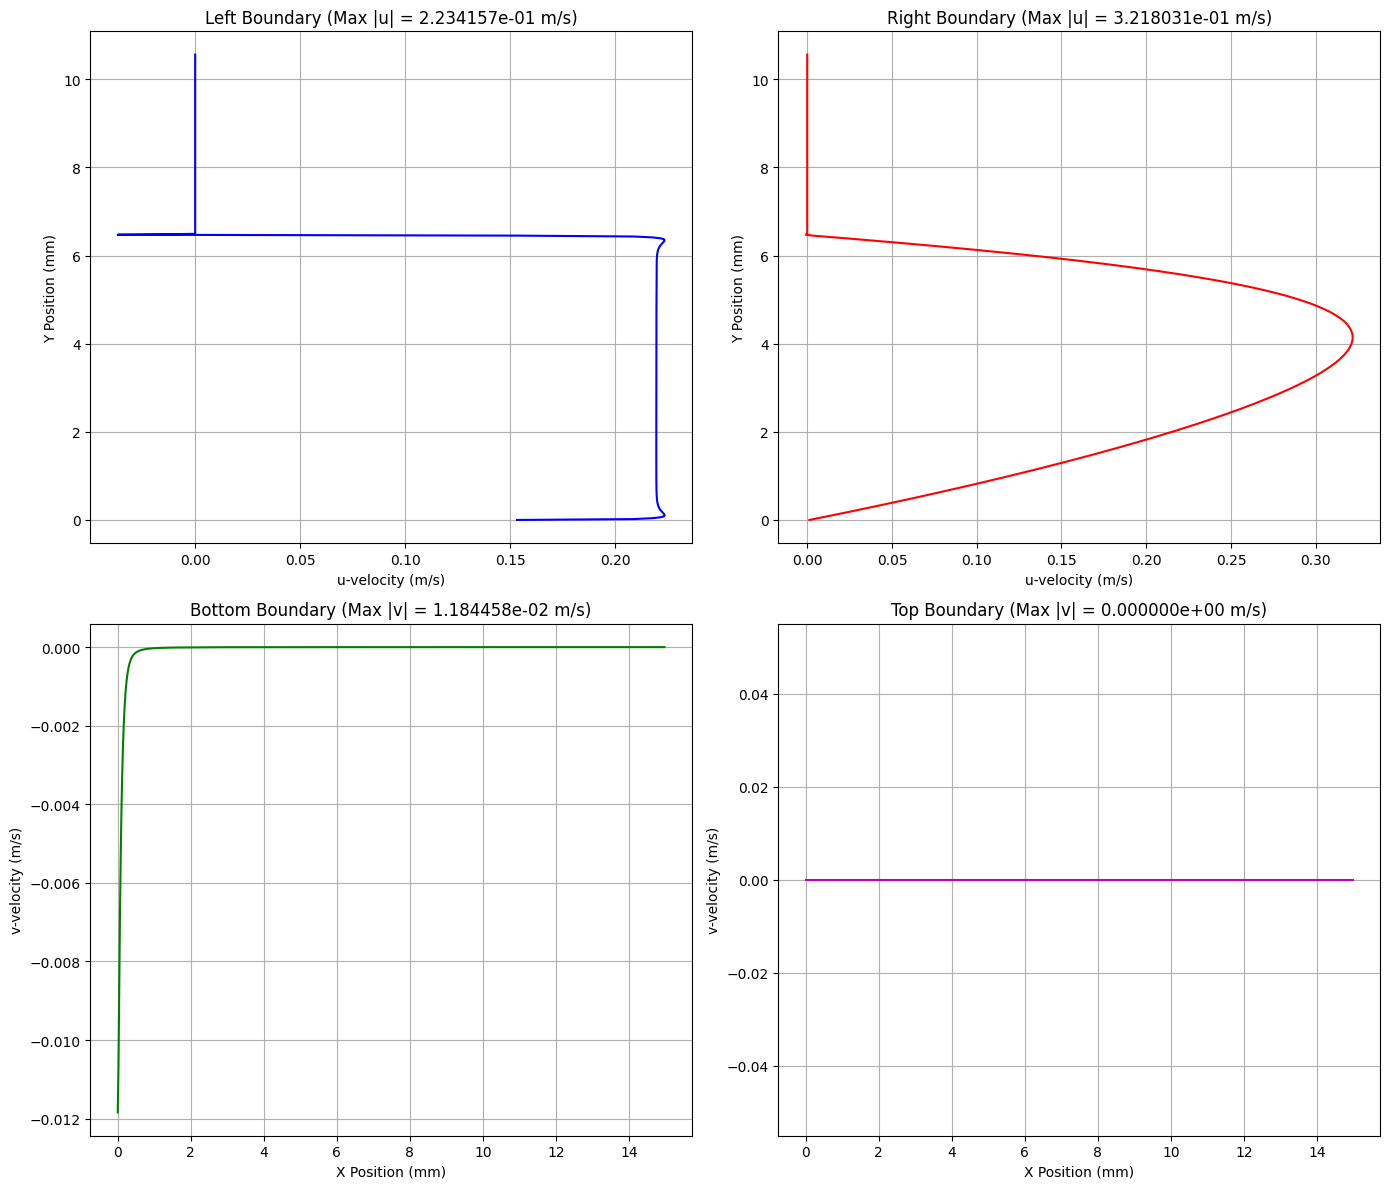

Maximum boundary leakage: 3.218031e-01 m/s
❌ Potential boundary leakage detected
  Left boundary: 2.234157e-01 m/s
  Right boundary: 3.218031e-01 m/s
  Bottom boundary: 1.184458e-02 m/s
  Top boundary: 0.000000e+00 m/s


In [34]:
def check_boundary_leakage(u, v):
    """
    Check for fluid leakage at domain boundaries by analyzing normal velocity components.
    """
    if u is None or v is None or u.ndim != 2 or v.ndim != 2:
        print("Velocity data not available in correct format")
        return
    
    # Get dimensions in physical units
    ny, nx = u.shape
    x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert to mm
    y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert to mm
    
    # Convert velocities to physical units (m/s)
    velocity_scale = dx / dt  # m/s per lattice unit
    u_phys = u * velocity_scale
    v_phys = v * velocity_scale
    
    # Check velocity normal to boundaries
    left_boundary_u = u_phys[:, 0]
    right_boundary_u = u_phys[:, -1]
    bottom_boundary_v = v_phys[0, :]
    top_boundary_v = v_phys[-1, :]
    
    # For solid boundaries, normal velocity should be zero
    left_leakage = np.abs(left_boundary_u).max()
    right_leakage = np.abs(right_boundary_u).max()
    bottom_leakage = np.abs(bottom_boundary_v).max()
    top_leakage = np.abs(top_boundary_v).max()
    
    # Plot boundary velocity profiles
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))
    
    # Left boundary
    axs[0, 0].plot(left_boundary_u, y_mm, 'b-')
    axs[0, 0].set_title(f'Left Boundary (Max |u| = {left_leakage:.6e} m/s)')
    axs[0, 0].set_xlabel('u-velocity (m/s)')
    axs[0, 0].set_ylabel('Y Position (mm)')
    axs[0, 0].grid(True)
    
    # Right boundary
    axs[0, 1].plot(right_boundary_u, y_mm, 'r-')
    axs[0, 1].set_title(f'Right Boundary (Max |u| = {right_leakage:.6e} m/s)')
    axs[0, 1].set_xlabel('u-velocity (m/s)')
    axs[0, 1].set_ylabel('Y Position (mm)')
    axs[0, 1].grid(True)
    
    # Bottom boundary
    axs[1, 0].plot(x_mm, bottom_boundary_v, 'g-')
    axs[1, 0].set_title(f'Bottom Boundary (Max |v| = {bottom_leakage:.6e} m/s)')
    axs[1, 0].set_xlabel('X Position (mm)')
    axs[1, 0].set_ylabel('v-velocity (m/s)')
    axs[1, 0].grid(True)
    
    # Top boundary
    axs[1, 1].plot(x_mm, top_boundary_v, 'm-')
    axs[1, 1].set_title(f'Top Boundary (Max |v| = {top_leakage:.6e} m/s)')
    axs[1, 1].set_xlabel('X Position (mm)')
    axs[1, 1].set_ylabel('v-velocity (m/s)')
    axs[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Assess leakage severity
    max_leakage = max(left_leakage, right_leakage, bottom_leakage, top_leakage)
    print(f"Maximum boundary leakage: {max_leakage:.6e} m/s")
    
    # Adjust threshold to physical units (typical threshold ~1 mm/s)
    threshold = 0.001  # 1 mm/s in m/s units
    if max_leakage < threshold:
        print("✅ No significant boundary leakage detected")
    else:
        print("❌ Potential boundary leakage detected")
        print(f"  Left boundary: {left_leakage:.6e} m/s")
        print(f"  Right boundary: {right_leakage:.6e} m/s")
        print(f"  Bottom boundary: {bottom_leakage:.6e} m/s")
        print(f"  Top boundary: {top_leakage:.6e} m/s")

# Check for boundary leakage if data is available and in the correct format
if 'u' in sim_data and 'v' in sim_data:
    # Make sure the data is in 2D format
    u_data = sim_data['u']
    v_data = sim_data['v']
    
    if u_data.ndim == 1 and v_data.ndim == 1:
        # Try to reshape using grid shape from parameters
        try:
            grid_shape = params['numerical']['grid_shape']
            dims = [dim for dim in grid_shape if dim > 1]
            if len(dims) == 2:
                ny, nx = dims[0], dims[1]
                u_data = u_data.reshape(ny, nx)
                v_data = v_data.reshape(ny, nx)
                print(f"Reshaped velocity data to {u_data.shape} for boundary leakage check")
            else:
                print("Could not determine 2D shape from parameters for boundary leakage check")
        except (KeyError, IndexError) as e:
            print(f"Error reshaping data for boundary leakage check: {e}")
    
    # Check for boundary leakage
    if u_data.ndim == 2 and v_data.ndim == 2:
        check_boundary_leakage(u_data, v_data)
    else:
        print("Velocity data not in correct format for boundary leakage check")
else:
    print("Velocity data not available for boundary leakage check.")

## Summary of Validation Results

Compile and present overall validation findings.

In [35]:
def summarize_validation_results():
    """
    Summarize all validation results in a single assessment.
    """
    if not sim_data:
        print("No simulation data available for validation summary")
        return
    
    print("=== IMPLEMENTATION VALIDATION SUMMARY ===")
    print()
    
    # Check data presence
    validation_checks = [
        ('Velocity Field (u, v)', ('u' in sim_data and 'v' in sim_data))
    ]
    
    print("Data Availability:")
    for check_name, check_result in validation_checks:
        status = "✅ Available" if check_result else "❌ Missing"
        print(f"  {check_name}: {status}")
    print()
    
    # Overall assessment
    if all(check_result for _, check_result in validation_checks):
        print("🟢 OVERALL ASSESSMENT: Implementation appears to have valid data available for analysis")
        print("Run the individual validation cells above to perform detailed validation tests.")
    else:
        print("🔴 OVERALL ASSESSMENT: Implementation has issues with data availability that require attention")

# Summarize validation results
summarize_validation_results()

=== IMPLEMENTATION VALIDATION SUMMARY ===

Data Availability:
  Velocity Field (u, v): ✅ Available

🟢 OVERALL ASSESSMENT: Implementation appears to have valid data available for analysis
Run the individual validation cells above to perform detailed validation tests.


## Conclusion

This notebook has provided tools for verifying the implementation of our fluid simulation by:

1. Visualizing the fluid flow to confirm proper containment within the domain
2. Verifying conservation of mass through divergence analysis
3. Checking boundaries for fluid leakage

These analyses help ensure our implementation correctly handles the physical constraints of incompressible fluid flow as described by the Navier-Stokes equations.

## Load and Visualize Aneurysm Simulation

Let's load the aneurysm geometry and visualize the first frame of the velocity field to examine the flow patterns.

Loading aneurysm simulation data from /home/abdua786/code/uni/3/dissertation/dissertation/visualisation_src/../results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh/processed_data/raw_fields
Loaded dimensions: [750 529   1]
Loaded velocity data with shape: (528, 749)
Loaded velocity data with shape: (528, 749)
Loaded velocity magnitude with shape: (528, 749)
Loaded wall mask with shape: (528, 749)
Loaded velocity magnitude with shape: (528, 749)
Loaded wall mask with shape: (528, 749)


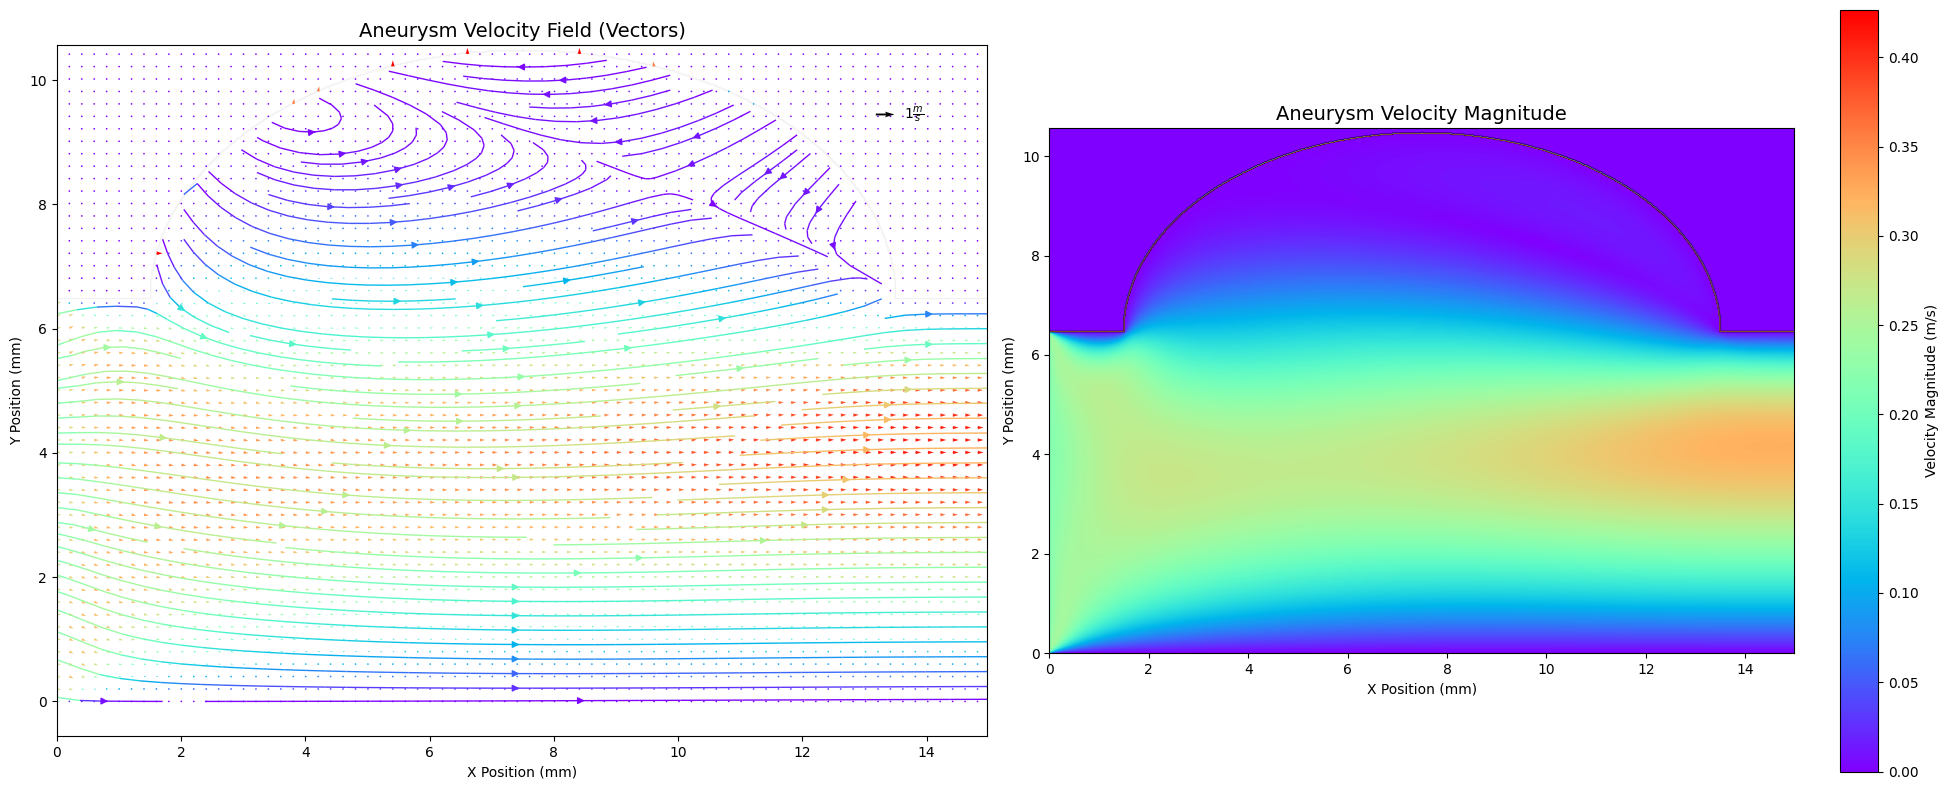

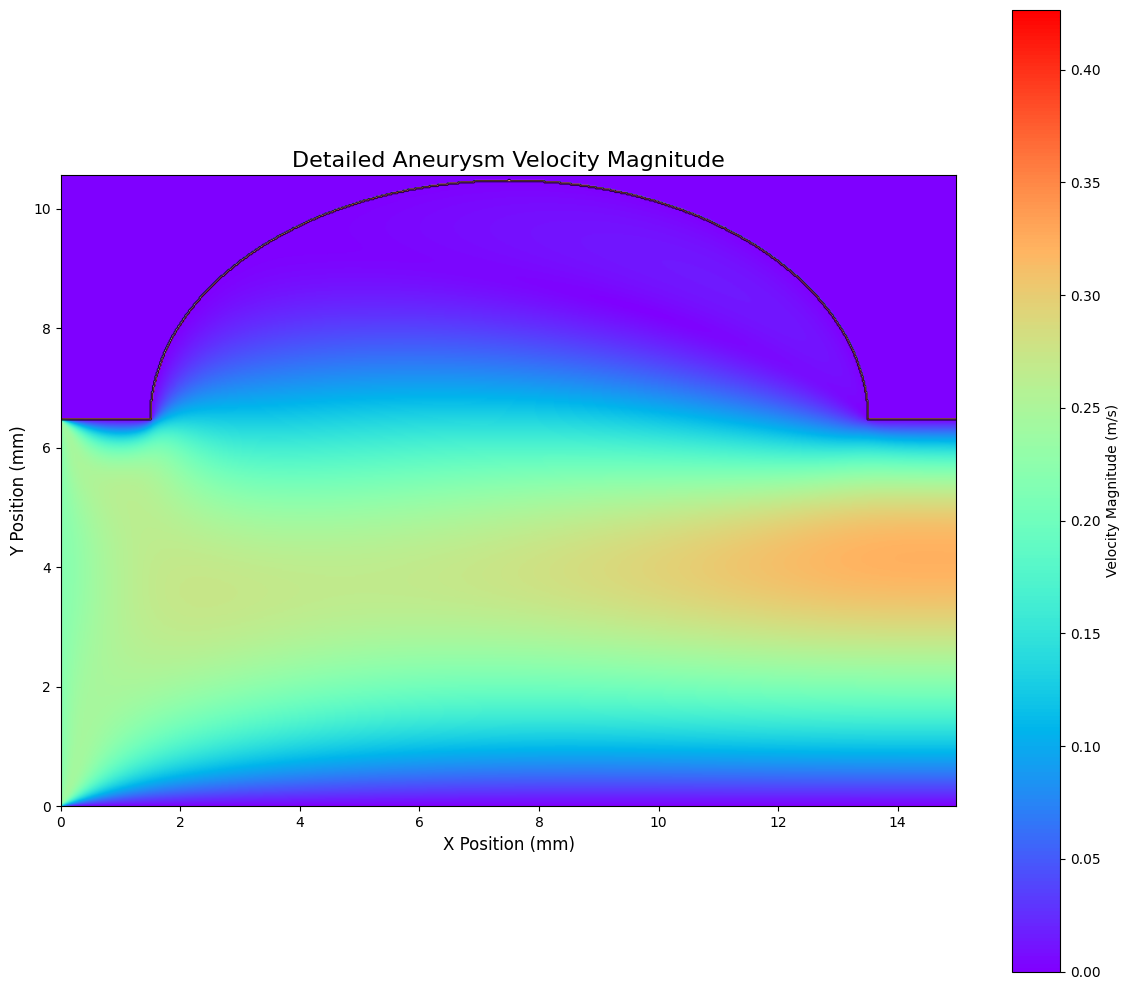

In [36]:
# Define aneurysm simulation folder (using existing simulation_folder)
aneurysm_folder = base_dir / '../results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh'

# Path to the processed data directory
data_dir = aneurysm_folder / 'processed_data' / 'raw_fields'

def load_aneurysm_simulation_data():
    """Load aneurysm simulation data from processed NPZ files"""
    print(f"Loading aneurysm simulation data from {data_dir}")
    
    data = {}
    # Try to load the data dimensions
    try:
        if (data_dir / 'dimensions.npz').exists():
            data['dimensions'] = np.load(data_dir / 'dimensions.npz')['data']
            print(f"Loaded dimensions: {data['dimensions']}")
        else:
            print("Dimensions file not found.")
        
        # Load velocity components (first frame only for visualization)
        if (data_dir / 'u_x.npz').exists() and (data_dir / 'u_y.npz').exists():
            data['u_x'] = np.load(data_dir / 'u_x.npz')['data'][0]  # First frame
            data['u_y'] = np.load(data_dir / 'u_y.npz')['data'][0]  # First frame
            print(f"Loaded velocity data with shape: {data['u_x'].shape}")
        
        # Load velocity magnitude (first frame only)
        if (data_dir / 'u_magnitude.npz').exists():
            data['u_magnitude'] = np.load(data_dir / 'u_magnitude.npz')['data'][0]  # First frame
            print(f"Loaded velocity magnitude with shape: {data['u_magnitude'].shape}")
        
        # Load wall mask if available (for domain visualization)
        if (data_dir / 'wall_mask.npz').exists():
            data['wall_mask'] = np.load(data_dir / 'wall_mask.npz')['data'][0]  # First frame
            print(f"Loaded wall mask with shape: {data['wall_mask'].shape}")
            
    except Exception as e:
        print(f"Error loading aneurysm data: {e}")
    
    return data

# Load the aneurysm simulation data
aneurysm_data = load_aneurysm_simulation_data()

# Visualize the aneurysm velocity field
def visualize_aneurysm_velocity(data):
    """Create a comprehensive visualization of the aneurysm velocity field"""
    if not data or 'u_x' not in data or 'u_y' not in data:
        print("Required velocity data not available.")
        return
    
    # Create a figure with two subplots: vector field and magnitude
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Get the velocity components
    u = data['u_x']
    v = data['u_y']
    
    # Calculate velocity magnitude if not available
    if 'u_magnitude' in data:
        vel_mag = data['u_magnitude']
    else:
        vel_mag = np.sqrt(u**2 + v**2)
    
    # Convert to physical units (m/s)
    velocity_scale = dx / dt  # m/s per lattice unit
    u_phys = u * velocity_scale
    v_phys = v * velocity_scale
    vel_mag_phys = vel_mag * velocity_scale
    
    # Get domain mask if available
    domain_mask = None
    if 'wall_mask' in data:
        domain_mask = data['wall_mask']
    
    # Calculate physical dimensions (mm)
    ny, nx = u.shape
    x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
    y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
    x_mg, y_mg = np.meshgrid(x_mm, y_mm)
    
    # Downsample for clearer vector visualization
    skip = max(1, min(nx, ny) // 50)
    
    # Velocity field visualization with vectors
    ax1.set_title('Aneurysm Velocity Field (Vectors)', fontsize=14)
    
    # If we have a domain mask, use it to show the fluid domain
    if domain_mask is not None:
        # Invert mask if needed (depends on convention - 1 for fluid, 0 for walls or vice versa)
        if domain_mask.dtype == bool or np.all(np.unique(domain_mask) <= 1):
            # Create a custom colormap for the domain: transparent for walls, light gray for fluid
            domain_cmap = plt.cm.colors.ListedColormap(['white', 'lightgray'])
            ax1.imshow(domain_mask, cmap=domain_cmap, alpha=0.3, origin='lower',
                      extent=[0, max(x_mm), 0, max(y_mm)])
    
    # Plot streamlines with physical units using rainbow colormap
    ax1.streamplot(x_mm, y_mm, u_phys, v_phys, density=1.5, color=vel_mag_phys, cmap='rainbow', linewidth=1)
    
    # Plot velocity vectors with physical units
    qv = ax1.quiver(x_mg[::skip, ::skip], y_mg[::skip, ::skip], 
                   u_phys[::skip, ::skip], v_phys[::skip, ::skip], 
                   vel_mag_phys[::skip, ::skip], cmap='rainbow', scale=50, width=0.002)
    ax1.quiverkey(qv, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E')
    
    ax1.set_xlabel('X Position (mm)')
    ax1.set_ylabel('Y Position (mm)')
    ax1.grid(False)
    
    # Velocity magnitude visualization with rainbow colormap
    ax2.set_title('Aneurysm Velocity Magnitude', fontsize=14)
    im = ax2.imshow(vel_mag_phys, origin='lower', cmap='rainbow',
                  extent=[0, max(x_mm), 0, max(y_mm)])
    plt.colorbar(im, ax=ax2, label='Velocity Magnitude (m/s)')
    
    # If we have the domain mask, overlay the domain boundary as a contour
    if domain_mask is not None:
        ax2.contour(x_mm, y_mm, domain_mask, levels=[0.5], colors='black', linewidths=0.5, alpha=0.7)
    
    ax2.set_xlabel('X Position (mm)')
    ax2.set_ylabel('Y Position (mm)')
    
    plt.tight_layout()
    plt.show()
    
    # Create a more detailed velocity magnitude plot for better visualization of flow patterns
    plt.figure(figsize=(12, 10))
    plt.title('Detailed Aneurysm Velocity Magnitude', fontsize=16)
    
    # Use rainbow colormap for better flow visualization
    im = plt.imshow(vel_mag_phys, origin='lower', cmap='rainbow', interpolation='bilinear',
                  extent=[0, max(x_mm), 0, max(y_mm)])
    plt.colorbar(im, label='Velocity Magnitude (m/s)')
    
    # If we have the domain mask, overlay the domain boundary
    if domain_mask is not None:
        plt.contour(x_mm, y_mm, domain_mask, levels=[0.5], colors='black', linewidths=0.8, alpha=0.7)
    
    # Add grid lines for reference
    plt.grid(False)
    plt.xlabel('X Position (mm)', fontsize=12)
    plt.ylabel('Y Position (mm)', fontsize=12)
    
    # Physical dimensions of the domain
    domain_width_mm = nx * dx * 1000
    domain_height_mm = ny * dx * 1000
    vessel_center_mm = params['input_parameters']['vessel_centre_lu'] * dx * 1000 if 'vessel_centre_lu' in params['input_parameters'] else domain_height_mm/2
    
    # Add annotations identifying key regions if data shape matches expectations
    nx_expected, ny_expected = 750, 529  # Expected dimensions for the aneurysm
    
    if ny == ny_expected and nx == nx_expected:
        # These are approximate positions based on prior knowledge of the aneurysm geometry
        plt.annotate('Inlet', xy=(domain_width_mm*0.067, vessel_center_mm), 
                    xytext=(domain_width_mm*0.04, vessel_center_mm-10), 
                    arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8), 
                    color='black', fontsize=12)
        
        plt.annotate('Aneurysm Dome', xy=(domain_width_mm*0.5, vessel_center_mm+20), 
                    xytext=(domain_width_mm*0.6, vessel_center_mm+30), 
                    arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8), 
                    color='black', fontsize=12)
        
        plt.annotate('Outlet', xy=(domain_width_mm*0.93, vessel_center_mm), 
                    xytext=(domain_width_mm*0.85, vessel_center_mm-10), 
                    arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8), 
                    color='black', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Visualize the aneurysm velocity field if data is available
if aneurysm_data:
    visualize_aneurysm_velocity(aneurysm_data)
else:
    print("No aneurysm simulation data available for visualization.")